<div style="background-color:#4c4893; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;">
<p style="color:yellow;font-weight:bold"><u>Réalisé par:</u></p>
<ul >
    <li>ELGHAZI Soufiane</li>
</ul>
    
</div>

<h1 style='color:orangered' align='center'>
    Projet d'Analyse Big Data : Prédiction de la Churn dans les Télécommunications
    <h2 style='color:olive' align='center'>
  Spark GraphX </h2>
</h1>

<div style="background-color:white; color:black; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid black;font-weight:bold;">
Dans ce Notebook on va explorer des analyses simples sur les graphes avec spark en utilisant un jeu de données d'un datacenter en effectuant des simples analyses sur les différents départements .<br>

</div>

---
---

<div style="background-color:pink; color:black; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid black;font-weight:bold;">
Tous d'abord on import les packages nécessaires :<br>

</div>

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import networkx as nx
import matplotlib.pyplot as plt

<div style="background-color:pink; color:black; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid black;font-weight:bold;">
Ensuite on initialise la session de spark <br>

</div>

In [2]:
spark = SparkSession.builder.appName("GraphAnalysis").getOrCreate()

<div style="background-color:pink; color:black; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid black;font-weight:bold;">
Ensuite on charge le fichier csv 
</div>

In [3]:
file_path="Call-Center-Dataset.csv"
df1 = spark.read.format("csv").option("header", "true").load(file_path)

<div style="background-color:pink; color:black; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid black;font-weight:bold;">
ensuite afficher les 5 premiers observations
</div>

In [4]:
df1.show(5)

+-------+--------------------+-------+---------------+--------------+--------+---------------+---------------+-------------------+
|Call Id|                Date|  Agent|     Department|Answered (Y/N)|Resolved|Speed of Answer|AvgTalkDuration|Satisfaction rating|
+-------+--------------------+-------+---------------+--------------+--------+---------------+---------------+-------------------+
| ID0001|2015-01-01 09:12:...|  Diane|Washing Machine|             Y|       Y|          109.0|00:02:23.210000|                3.0|
| ID0002|2015-01-01 09:12:...|  Becky|Air Conditioner|             Y|       N|           70.0|00:04:02.323000|                3.0|
| ID0003|2015-01-01 09:47:...|Stewart|Washing Machine|             Y|       Y|           10.0|00:02:11.202000|                3.0|
| ID0004|2015-01-01 09:47:...|   Greg|Washing Machine|             Y|       Y|           53.0|00:00:37.481000|                2.0|
| ID0005|2015-01-01 10:00:...|  Becky|        Toaster|             Y|       Y|     

<div style="background-color:pink; color:black; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid black;font-weight:bold;">
En remarquant que les données présents des valeurs manquantes , ducoup on va les supprimer , en plus pour eviter les problème des noms des colonnes on va les renommer :

</div>

In [5]:
df_cleaned = df1.dropna()
# Remplacer les espaces dans les colonnes avec _ et les rendre en miniscules
for column in df_cleaned.columns:
    df_cleaned = df_cleaned.withColumnRenamed(column, column.replace(' ', '_').lower())
df_cleaned.count()

4054

<div style="background-color:pink; color:black; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid black;font-weight:bold;">
et on affiche : <br>

</div>

In [6]:
df_cleaned.show(2)

+-------+--------------------+-----+---------------+--------------+--------+---------------+---------------+-------------------+
|call_id|                date|agent|     department|answered_(y/n)|resolved|speed_of_answer|avgtalkduration|satisfaction_rating|
+-------+--------------------+-----+---------------+--------------+--------+---------------+---------------+-------------------+
| ID0001|2015-01-01 09:12:...|Diane|Washing Machine|             Y|       Y|          109.0|00:02:23.210000|                3.0|
| ID0002|2015-01-01 09:12:...|Becky|Air Conditioner|             Y|       N|           70.0|00:04:02.323000|                3.0|
+-------+--------------------+-----+---------------+--------------+--------+---------------+---------------+-------------------+
only showing top 2 rows



<div style="background-color:pink; color:black; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid black;font-weight:bold;">
maintenant on va convertir vers pandas dataframe <br>

</div>

In [7]:
pdf = df_cleaned.toPandas()

In [8]:
pdf.head()

,call_id,date,agent,department,answered_(y/n),resolved,speed_of_answer,avgtalkduration,satisfaction_rating
0,ID0001,2015-01-01 09:12:58.000,Diane,Washing Machine,Y,Y,109.0,00:02:23.210000,3.0
1,ID0002,2015-01-01 09:12:57.600,Becky,Air Conditioner,Y,N,70.0,00:04:02.323000,3.0
2,ID0003,2015-01-01 09:47:31.200,Stewart,Washing Machine,Y,Y,10.0,00:02:11.202000,3.0
3,ID0004,2015-01-01 09:47:31.200,Greg,Washing Machine,Y,Y,53.0,00:00:37.481000,2.0
4,ID0005,2015-01-01 10:00:28.800,Becky,Toaster,Y,Y,95.0,00:01:00.083000,3.0


In [9]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4054 entries, 0 to 4053
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   call_id              4054 non-null   object
 1   date                 4054 non-null   object
 2   agent                4054 non-null   object
 3   department           4054 non-null   object
 4   answered_(y/n)       4054 non-null   object
 5   resolved             4054 non-null   object
 6   speed_of_answer      4054 non-null   object
 7   avgtalkduration      4054 non-null   object
 8   satisfaction_rating  4054 non-null   object
dtypes: object(9)
memory usage: 285.2+ KB


<div style="background-color:pink; color:black; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid black;font-weight:bold;">
Due au problème liée au package graphframes avec Python ,on va opter par le package networkx qui va nous permettre de travailler avec les graphes égalements <br>

</div>

C:\Users\Admin\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:304: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowsize.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


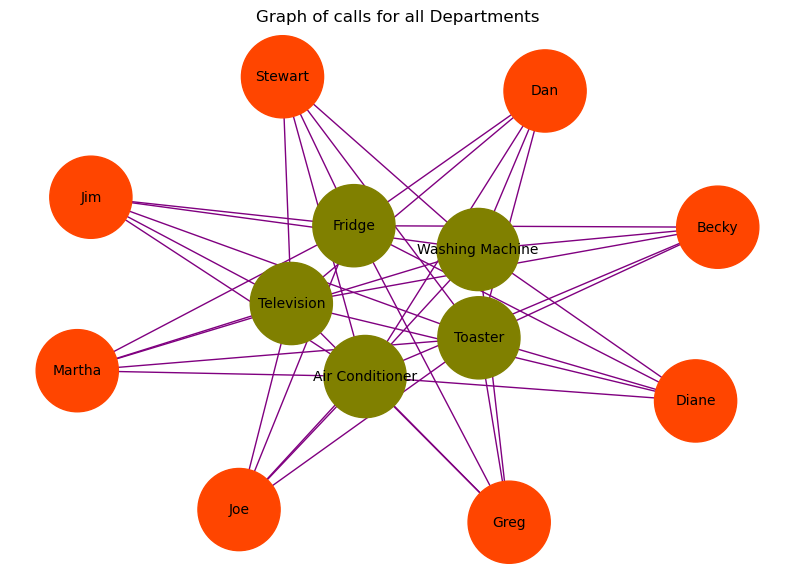

In [10]:
# créer le graph
G = nx.from_pandas_edgelist(pdf, source="agent", target="department")

# créer une color map pour les noeuds en se basant sur leurs attributs
node_color_map = {
    node: 'orangered' if pdf.loc[pdf['agent'] == node].shape[0] > 0 else 'olive' for node in G.nodes
}

# dessiner le graph
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 7))

# afficher le titre
plt.title("Graph of calls for all Departments")

# dessiner les noeudds avec les couleurs spécifier
nx.draw(G, with_labels=True, pos=pos, node_size=3500, node_color=[node_color_map[node] for node in G.nodes], edge_color='purple', arrowsize=33, font_size=10)

# afficher le plot
plt.show()

<div style="background-color:yellow; color:black; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid black;font-weight:bold;">
Ce graph nous affiche les agents liés au différents départements de datacenter .<br>

</div>

<div style="text-align:center;height:70;border: 5px solid black;font-weight:bold;">
    <img src="https://miro.medium.com/v2/resize:fit:1200/1*gdH6JmSIOf0JxtNWhN6yjg.png" width="700" alt="image1">
</div>

   


<div style="background-color:black; color:white; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid black;font-weight:bold;">
    
<span style="color:yellow">Centralité de Proximité (Closeness Centrality) :</span><br>
<span style="color:orangered">Définition:</span>La centralité de proximité mesure la proximité d'un nœud par rapport à tous les autres nœuds du réseau. Elle est calculée comme l'inverse de la distance moyenne la plus courte du nœud à tous les autres nœuds.<br>
<span style="color:orangered">Importance:</span>Les nœuds ayant une centralité de proximité élevée sont plus centraux dans le réseau et peuvent atteindre les autres nœuds plus rapidement. Dans le contexte des réseaux sociaux, les individus ayant une centralité de proximité élevée peuvent être bien connectés et avoir un accès rapide à l'information.<br><br>
    
<span style="color:yellow">Centralité de Degré (Degree Centrality) :</span><br>
<span style="color:orangered">Définition:</span> La centralité degré est la mesure de centralité la plus simple et est basée sur le nombre d'arêtes (connexions) qu'un nœud a. Elle représente le nombre de liens incidents sur un nœud.<br>
<span style="color:orangered">Importance:</span> Les nœuds ayant une centralité degré élevée sont plus connectés et peuvent jouer un rôle crucial dans le flux d'information. Dans les réseaux sociaux, les individus ayant une centralité degré élevée peuvent avoir plus de connexions directes, ce qui les rend potentiellement influents.<br><br>

<span style="color:yellow">Centralité d'Intermédiarité (Betweenness Centrality) :</span><br>
<span style="color:orangered">Définition:</span> La centralité d'intermédiarité quantifie le nombre de fois qu'un nœud agit comme un pont (ou se trouve sur les chemins les plus courts) entre d'autres paires de nœuds dans le réseau. Elle est calculée en fonction du nombre de chemins les plus courts qui passent par le nœud.<br>
<span style="color:orangered">Importance:</span> Les nœuds ayant une centralité d'intermédiarité élevée agissent comme des intermédiaires ou des garde-barrières dans le réseau. Ils contrôlent le flux d'information entre différentes parties du réseau. Dans les réseaux sociaux, les individus ayant une centralité d'intermédiarité élevée peuvent être cruciaux pour maintenir la communication entre différents groupes.<br><br>
    
Dans le contexte de l'analyse de notre graphique de centre d'appels :

<span style="color:pink">Centralité de Proximité :</span> Identifie les agents ou départements rapidement accessibles aux autres.<br>
<span style="color:cyan">Centralité de Degré :</span> Met en évidence les agents ou départements ayant un nombre élevé de connexions directes.<br>
<span style="color:orange">Centralité d'Intermédiarité :</span> Repère les agents ou départements agissant comme intermédiaires dans le réseau de communication.<br>

</div>

<div style="background-color:pink; color:black; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid black;font-weight:bold;">
Maintenant on va créer une fonction python qui va nous permet d'afficher les graphes des appels effectuer au département spécifie et qui porte le niveau de satisfaction elevée 5

</div>

In [18]:
def analyze_department(department, pdf):
    # Filtrer DataFrame en se basant sur degre de satisfaction 5 .
    filtered_df = pdf[
        (pdf['department'].str.lower().str.strip().str.contains(department.lower())) & 
        (pdf['satisfaction_rating'].str.strip().str.contains('5'))
    ]
    # créer le graph ,networkx avec les poids d'arrets en se basant sur l'id des appels
    G = nx.from_pandas_edgelist(filtered_df, source="agent", target="department", edge_attr="call_id", create_using=nx.DiGraph())
    # dessiner le graph
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(G)
    # aficher le titre 
    plt.title(f"Graph of calls with Satisfaction Rating 5 for {department} Department")
    # dessiner le graph avec les poids des arretes
    nx.draw(G, with_labels=True, pos=pos, node_size=3500, node_color='olive', font_size=10, edge_color='purple', arrowsize=33)
    edge_labels = nx.get_edge_attributes(G, 'call_id')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    # ploter le graph 
    plt.show()
    # Calculate Closeness Centrality
    closeness_centrality = nx.closeness_centrality(G)
    # Centrality
    degree_centrality = nx.degree_centrality(G)
    # Betweenness Centrality
    betweenness_centrality = nx.betweenness_centrality(G)
    # Closeness Centrality
    display_top_departments(closeness_centrality, f"{department} - Closeness Centrality")
    # Degree Centrality
    display_top_departments(degree_centrality, f"{department} - Degree Centrality")
    # Betweenness Centrality
    display_top_departments(betweenness_centrality, f"{department} - Betweenness Centrality")
    return G, closeness_centrality, degree_centrality, betweenness_centrality

def display_top_departments(centrality_measure, title, k=2):
    sorted_departments = sorted(centrality_measure.items(), key=lambda x: x[1], reverse=True)
    top_departments = sorted_departments[:k]
    print(f"{title}:\n")
    for department, centrality in top_departments:
        print(f"Department: {department}, Centrality: {centrality:.4f}")
    print("\n")

<div style="background-color:brown; color:white; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid black;font-weight:bold;text-align:center">
Departement Fridge<br>

</div>

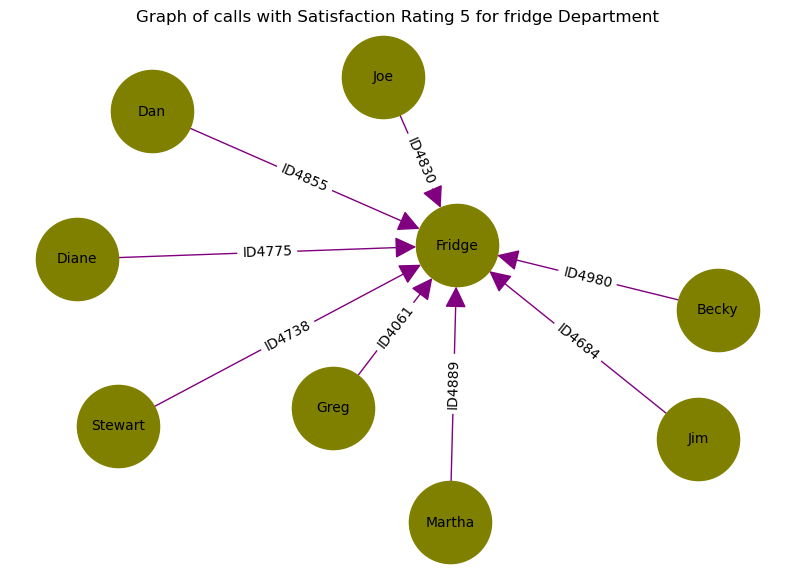

fridge - Closeness Centrality:

Department: Fridge, Centrality: 1.0000
Department: Dan, Centrality: 0.0000


fridge - Degree Centrality:

Department: Fridge, Centrality: 1.0000
Department: Dan, Centrality: 0.1250


fridge - Betweenness Centrality:

Department: Dan, Centrality: 0.0000
Department: Fridge, Centrality: 0.0000




In [12]:
G_fridge, closeness_fridge, degree_fridge, betweenness_fridge = analyze_department("fridge", pdf)

In [21]:
print("closeness_fridge: ",closeness_fridge,"\n\n degree_fridge :", degree_fridge,"\n\n betweenness_fridge", betweenness_fridge)

closeness_fridge:  {'Dan': 0.0, 'Fridge': 1.0, 'Diane': 0.0, 'Stewart': 0.0, 'Becky': 0.0, 'Joe': 0.0, 'Martha': 0.0, 'Jim': 0.0, 'Greg': 0.0} 

 degree_fridge : {'Dan': 0.125, 'Fridge': 1.0, 'Diane': 0.125, 'Stewart': 0.125, 'Becky': 0.125, 'Joe': 0.125, 'Martha': 0.125, 'Jim': 0.125, 'Greg': 0.125} 

 betweenness_fridge {'Dan': 0.0, 'Fridge': 0.0, 'Diane': 0.0, 'Stewart': 0.0, 'Becky': 0.0, 'Joe': 0.0, 'Martha': 0.0, 'Jim': 0.0, 'Greg': 0.0}


<div style="background-color:brown; color:white; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid black;font-weight:bold;text-align:center">
Departement Washing Machine<br>

</div>

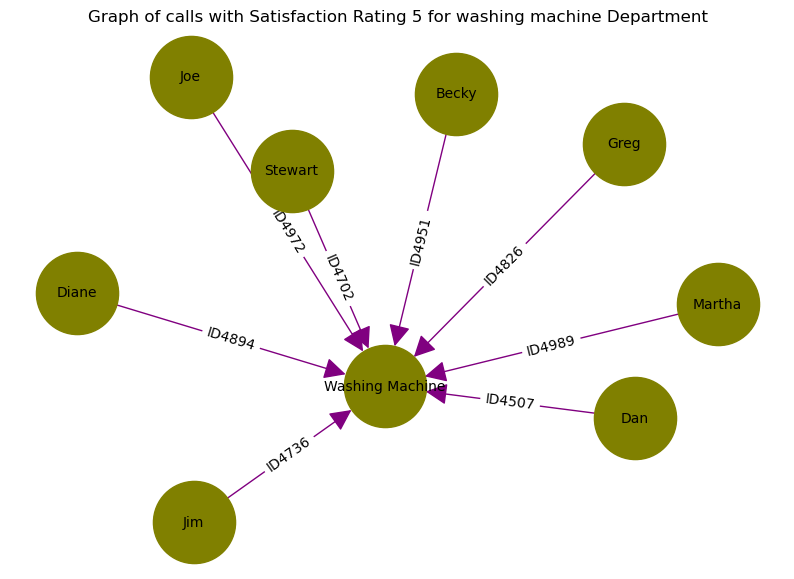

washing machine - Closeness Centrality:

Department: Washing Machine, Centrality: 1.0000
Department: Greg, Centrality: 0.0000


washing machine - Degree Centrality:

Department: Washing Machine, Centrality: 1.0000
Department: Greg, Centrality: 0.1250


washing machine - Betweenness Centrality:

Department: Greg, Centrality: 0.0000
Department: Washing Machine, Centrality: 0.0000




In [13]:
G_washing, closeness_washing, degree_washing, betweenness_washing = analyze_department("washing machine", pdf)

In [23]:
print("closeness_washing: ",closeness_washing,"\n\n degree_washing :", degree_washing,"\n\n betweenness_washing", betweenness_washing)

closeness_washing:  {'Greg': 0.0, 'Washing Machine': 1.0, 'Jim': 0.0, 'Stewart': 0.0, 'Becky': 0.0, 'Joe': 0.0, 'Dan': 0.0, 'Diane': 0.0, 'Martha': 0.0} 

 degree_washing : {'Greg': 0.125, 'Washing Machine': 1.0, 'Jim': 0.125, 'Stewart': 0.125, 'Becky': 0.125, 'Joe': 0.125, 'Dan': 0.125, 'Diane': 0.125, 'Martha': 0.125} 

 betweenness_washing {'Greg': 0.0, 'Washing Machine': 0.0, 'Jim': 0.0, 'Stewart': 0.0, 'Becky': 0.0, 'Joe': 0.0, 'Dan': 0.0, 'Diane': 0.0, 'Martha': 0.0}


<div style="background-color:brown; color:white; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid black;font-weight:bold;text-align:center">
Departement Air Conditioner<br>

</div>

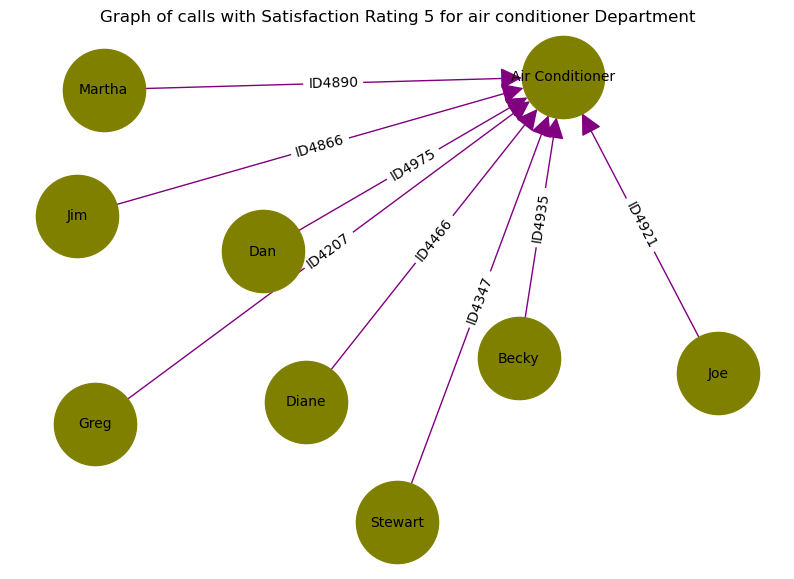

air conditioner - Closeness Centrality:

Department: Air Conditioner, Centrality: 1.0000
Department: Greg, Centrality: 0.0000


air conditioner - Degree Centrality:

Department: Air Conditioner, Centrality: 1.0000
Department: Greg, Centrality: 0.1250


air conditioner - Betweenness Centrality:

Department: Greg, Centrality: 0.0000
Department: Air Conditioner, Centrality: 0.0000




In [14]:
G_air, closeness_air, degree_air, betweenness_air = analyze_department("air conditioner", pdf)

In [24]:
print("closeness_air: ",closeness_air,"\n\n degree_air :", degree_air,"\n\n betweenness_air", betweenness_air)

closeness_air:  {'Greg': 0.0, 'Air Conditioner': 1.0, 'Jim': 0.0, 'Joe': 0.0, 'Dan': 0.0, 'Becky': 0.0, 'Diane': 0.0, 'Martha': 0.0, 'Stewart': 0.0} 

 degree_air : {'Greg': 0.125, 'Air Conditioner': 1.0, 'Jim': 0.125, 'Joe': 0.125, 'Dan': 0.125, 'Becky': 0.125, 'Diane': 0.125, 'Martha': 0.125, 'Stewart': 0.125} 

 betweenness_air {'Greg': 0.0, 'Air Conditioner': 0.0, 'Jim': 0.0, 'Joe': 0.0, 'Dan': 0.0, 'Becky': 0.0, 'Diane': 0.0, 'Martha': 0.0, 'Stewart': 0.0}


<div style="background-color:brown; color:white; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid black;font-weight:bold;text-align:center">
Departement Toaster<br>

</div>

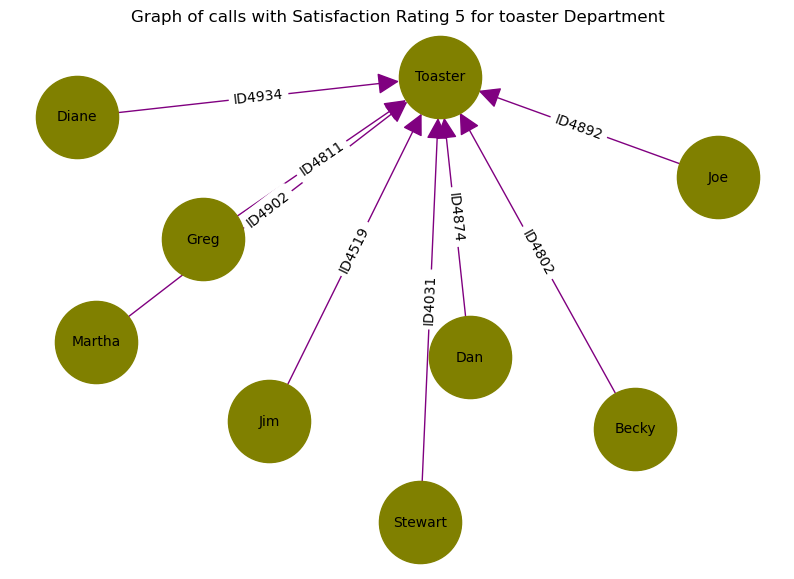

toaster - Closeness Centrality:

Department: Toaster, Centrality: 1.0000
Department: Becky, Centrality: 0.0000


toaster - Degree Centrality:

Department: Toaster, Centrality: 1.0000
Department: Becky, Centrality: 0.1250


toaster - Betweenness Centrality:

Department: Becky, Centrality: 0.0000
Department: Toaster, Centrality: 0.0000




In [15]:
G_toa, closeness_toa, degree_toa, betweenness_toa = analyze_department("toaster", pdf)

In [25]:
print("closeness_toa: ",closeness_toa,"\n\n degree_toa :", degree_toa,"\n\n betweenness_toa", betweenness_toa)

closeness_toa:  {'Becky': 0.0, 'Toaster': 1.0, 'Stewart': 0.0, 'Dan': 0.0, 'Greg': 0.0, 'Joe': 0.0, 'Diane': 0.0, 'Martha': 0.0, 'Jim': 0.0} 

 degree_toa : {'Becky': 0.125, 'Toaster': 1.0, 'Stewart': 0.125, 'Dan': 0.125, 'Greg': 0.125, 'Joe': 0.125, 'Diane': 0.125, 'Martha': 0.125, 'Jim': 0.125} 

 betweenness_toa {'Becky': 0.0, 'Toaster': 0.0, 'Stewart': 0.0, 'Dan': 0.0, 'Greg': 0.0, 'Joe': 0.0, 'Diane': 0.0, 'Martha': 0.0, 'Jim': 0.0}


<div style="background-color:brown; color:white; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid black;font-weight:bold;text-align:center">
Departement Television<br>

</div>

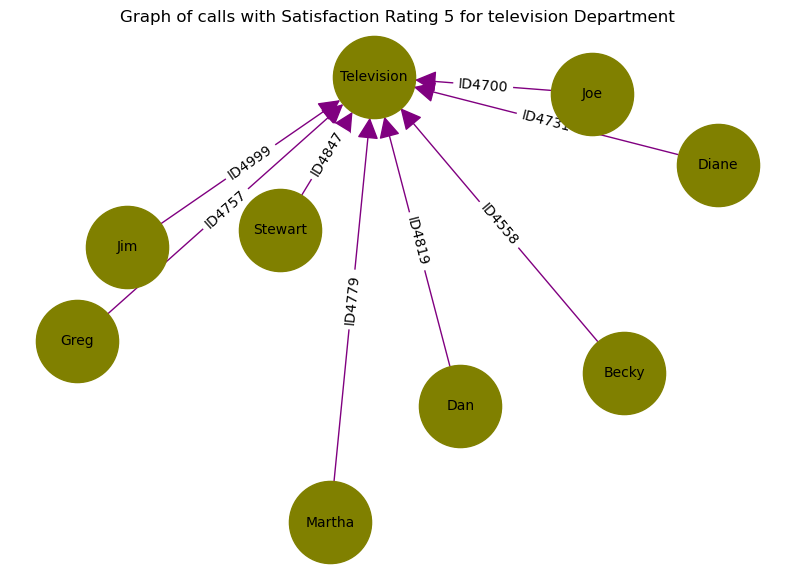

television - Closeness Centrality:

Department: Television, Centrality: 1.0000
Department: Becky, Centrality: 0.0000


television - Degree Centrality:

Department: Television, Centrality: 1.0000
Department: Becky, Centrality: 0.1250


television - Betweenness Centrality:

Department: Becky, Centrality: 0.0000
Department: Television, Centrality: 0.0000




In [16]:
G_tel, closeness_tel, degree_tel, betweenness_tel = analyze_department("television", pdf)

In [26]:
print("closeness_tel: ",closeness_tel,"\n\n degree_tel :", degree_tel,"\n\n betweenness_tel", betweenness_tel)

closeness_tel:  {'Becky': 0.0, 'Television': 1.0, 'Joe': 0.0, 'Diane': 0.0, 'Greg': 0.0, 'Jim': 0.0, 'Dan': 0.0, 'Stewart': 0.0, 'Martha': 0.0} 

 degree_tel : {'Becky': 0.125, 'Television': 1.0, 'Joe': 0.125, 'Diane': 0.125, 'Greg': 0.125, 'Jim': 0.125, 'Dan': 0.125, 'Stewart': 0.125, 'Martha': 0.125} 

 betweenness_tel {'Becky': 0.0, 'Television': 0.0, 'Joe': 0.0, 'Diane': 0.0, 'Greg': 0.0, 'Jim': 0.0, 'Dan': 0.0, 'Stewart': 0.0, 'Martha': 0.0}


<div style="background-color:black; color:white; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid black;font-weight:bold;">
    
<span style="color:yellow">Algorithme PageRank :</span><br><br>
<span style="color:orangered"> Définition:</span>PageRank est un algorithme utilisé par Google Search pour classer les pages web dans les résultats des moteurs de recherche. Il attribue un poids numérique à chaque élément d'un ensemble de documents hyperliés, représentant la probabilité qu'un utilisateur suive un lien particulier.<br><br>
<span style="color:orangered">Importance:</span> Dans le graphique de notre centre d'appels, on peut appliquer PageRank pour identifier les agents ou départements les plus influents en fonction de leurs connexions.<br> <div style="color:cyan">Les agents ou départements avec des valeurs de PageRank plus élevées peuvent être considérés comme plus centraux ou importants dans le réseau de communication.
   
</div>

In [17]:
pagerank_values = nx.pagerank(G)
top_agents_by_pagerank = sorted(pagerank_values.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top Agents by PageRank:")
for agent, pagerank in top_agents_by_pagerank:
    print(f"Departement/agent: {agent}, PageRank: {pagerank:.4f}")

Top Agents by PageRank:
Departement: Washing Machine, PageRank: 0.0981
Departement: Air Conditioner, PageRank: 0.0981
Departement: Toaster, PageRank: 0.0981
Departement: Fridge, PageRank: 0.0981
Departement: Television, PageRank: 0.0981


<div style="background-color:orange; color:black; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid black;font-weight:bold;text-align:center">
    
<span style="color:blue">Conclusion :</span><br>
On peut conlcure d'après ces simples analyse que les départements présentent approximativement les même importance pour les appels qui ont le niveau de satisfaction elevé , cepandant il'est nécessaires d'explorer les autres niveau de satisfaction en plus d'autre analyses pour conclure plus d'insights sur ce datacenter <br>

</div>

---
<div style="background-color:yellow; color:black; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;">
<ul>
<li><a href="https://towardsdatascience.com/notes-on-graph-theory-centrality-measurements-e37d2e49550a" style="color:black;"> Graph Centrality</a></li>
<li><a href="https://graphframes.github.io/graphframes/docs/_site/index.html" style="color:black;"> Graphrames</a></li>
<li><a href="https://www.sciencedirect.com/topics/computer-science/closeness-centrality#:~:text=require%20many%20steps.-,Closeness%20centrality%20is%20a%20measure%20of%20the%20average%20shortest%20distance,distance%20to%20all%20other%20vertices)." style="color:black;"> Closeness Centrality </a></li>
<li><a href="https://www.sciencedirect.com/topics/computer-science/degree-centrality#:~:text=Degree%20centrality%20is%20one%20of,high%20centrality%20by%20other%20measures." style="color:black;"> Degree Centrality </a></li>
<li><a href="https://www.sciencedirect.com/topics/computer-science/betweenness-centrality#:~:text=The%20betweenness%20centrality%20captures%20how,v%2Cw(u))." style="color:black;"> Betweenness Centrality </a></li>
  
    
</ul>
</div>

---

<h2 style='color:orangered' align='center'>END </h2>